# CS573 project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suvroo/amex-variable-strategy-development-dataset")

print("Path to dataset files:", path)

100%|██████████| 19.7M/19.7M [00:00<00:00, 65.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suvroo/amex-variable-strategy-development-dataset/versions/3


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
import kagglehub

In [ ]:
path="/root/.cache/kagglehub/datasets/suvroo/amex-variable-strategy-development-dataset/versions/3"
filename1="Book1.xlsx"
file_path = os.path.join(path,filename1)

# Data cleaning

df = pd.read_excel(file_path)

is_unique = not df['unique_identifier'].duplicated().any()
if is_unique:
    print("All values in unique_identifier column are unique.")
else:
    print("Values in unique_identifier column are not unique.")

df['appl_month'] = pd.to_datetime(df['appl_month'], format='%b').dt.month
# Modify prod_name column (assumed format "Product [number]")
df['prod_name'] = df['prod_name'].str.extract(r'Product\s*(\d+)')
# Modify acq_channel column (assumed format "Channel [number]")
df['acq_channel'] = df['acq_channel'].str.extract(r'Channel\s*(\d+)')
# Assign numerical codes to state_code based on alphabetical order
df['state_code'] = pd.Categorical(df['state_code'], categories=sorted(df['state_code'].unique()), ordered=True).codes
# Assign numerical values to bureau_src
bureau_mapping = {'No Bureau Hit': 0, 'Bureau 1': 1, 'Bureau 2': 2}
df['bureau_src'] = df['bureau_src'].map(bureau_mapping)
mapping = {'N': 0, 'Y': 1, 'NA': 2}
df['trust_identity'] = df['trust_identity'].replace(mapping)
df['addr_mismatch'] = df['addr_mismatch'].replace(mapping)

StandardedDataColumn = [
    'bureau_score',
    'risk_score_1',
    'risk_score_2',
    'risk_score_3',
    'risk_score_4',
    'risk_score_5',
    'risk_score_6',
    'risk_score_7',
    'risk_score_8',
    'risk_score_9',
    'risk_score_10',
    'risk_score_11'
]

def GaussianNormal(series, a=0, b=1):
    mean = series.mean()
    std = series.std()
    normalized = (series - mean) / std

    scaled = a + (b - a) * (norm.cdf(normalized))
    return scaled

def Discretize(series, n_bins=20):
    min_val = series.min()
    max_val = series.max()

    bins = np.linspace(min_val, max_val, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_indices = pd.cut(series, bins=bins, labels=False, include_lowest=True)
    discretized = bin_centers[bin_indices]
    return discretized

def clean_data(df, columns, method='GaussianNormal', **kwargs):
    for column in columns:
        if column in df.columns:
            if method == 'GaussianNormal':
                df[column] = GaussianNormal(df[column], **kwargs)
            elif method == 'Discretize':
                df[column] = Discretize(df[column], **kwargs)
            else:
                print(f"Unknown method '{method}' for column '{column}'")
    return df

df_cleaned = clean_data(df, StandardedDataColumn, method='GaussianNormal', a=0, b=1)
# df_cleaned = clean_data(df, StandardedDataColumn, method='Discretize', n_bins=5)

# print(df.head(20))

# file_name = "Book2.xlsx"
# file_path = os.path.join(path, file_name)
# df.to_excel(file_path, index=False)


All values in unique_identifier column are unique.


<ipython-input-5-700099165c12>:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['trust_identity'] = df['trust_identity'].replace(mapping)
<ipython-input-5-700099165c12>:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['addr_mismatch'] = df['addr_mismatch'].replace(mapping)


In [ ]:
# correlation and normalization
import os
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("chenzhejin/amex-cleaned-data-for-course-project")

print("Path to dataset files:", path)
path = "/root/.cache/kagglehub/datasets/chenzhejin/amex-cleaned-data-for-course-project/versions/2"
filename = "Book2.xlsx"
file_path = os.path.join(path, filename)
# file_path = "/content/Book2.xlsx"
df = pd.read_excel(file_path)

100%|██████████| 19.3M/19.3M [00:00<00:00, 112MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chenzhejin/amex-cleaned-data-for-course-project/versions/2


In [ ]:
# Replace NaN with 2 in both columns
df['trust_identity'] = df['trust_identity'].fillna(2)
df['addr_mismatch'] = df['addr_mismatch'].fillna(2)

# Print the updated columns to confirm
print(df['trust_identity'])
print(df['addr_mismatch'])

0        2.0
1        1.0
2        0.0
3        2.0
4        1.0
        ... 
62479    2.0
62480    2.0
62481    2.0
62482    2.0
62483    2.0
Name: trust_identity, Length: 62484, dtype: float64
0        2.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
62479    0.0
62480    2.0
62481    0.0
62482    0.0
62483    0.0
Name: addr_mismatch, Length: 62484, dtype: float64


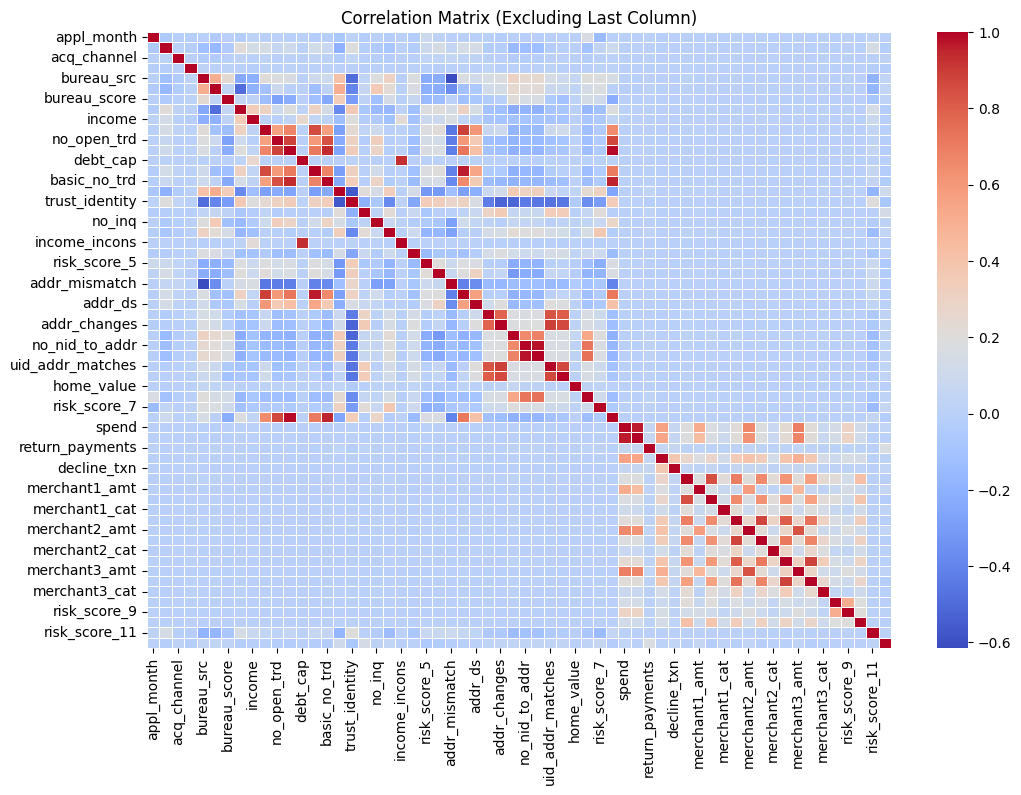

In [ ]:
# Select all columns except the first one
df_subset = df.iloc[:, 1:]

# Calculate the correlation matrix
corr_matrix = df_subset.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Excluding Last Column)")
plt.show()

In [ ]:
# Find and print all variable pairs with correlation greater than 0.85
high_corr_pairs = []

for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
n=0
# Display all variable pairs with correlation > 0.85
for pair in high_corr_pairs:
    n += 1
    print(f"Variables{n}: {pair[0]} and {pair[1]}, Correlation: {pair[2]:.2f}")

Variables1: old_open_trd_ms and basic_max_trd_tnr, Correlation: 0.86
Variables2: old_open_trd_ms and basic_old_open_trd_ms, Correlation: 0.89
Variables3: no_open_trd and no_trd, Correlation: 0.88
Variables4: no_open_trd and no_trd_del, Correlation: 0.87
Variables5: no_trd and basic_no_trd, Correlation: 0.94
Variables6: no_trd and no_trd_del, Correlation: 0.99
Variables7: debt_cap and income_incons, Correlation: 0.94
Variables8: basic_max_trd_tnr and basic_old_open_trd_ms, Correlation: 0.97
Variables9: basic_no_trd and no_trd_del, Correlation: 0.95
Variables10: addr_changes and uid_addr_matches, Correlation: 0.89
Variables11: addr_changes and uid_nid_matches, Correlation: 0.87
Variables12: no_nid_to_addr and no_uid_to_addr, Correlation: 0.98
Variables13: uid_addr_matches and uid_nid_matches, Correlation: 0.87
Variables14: spend and payments, Correlation: 0.97
Variables15: merchant1 and merchant1_ten, Correlation: 0.85
Variables16: merchant2 and merchant2_ten, Correlation: 0.88
Variables

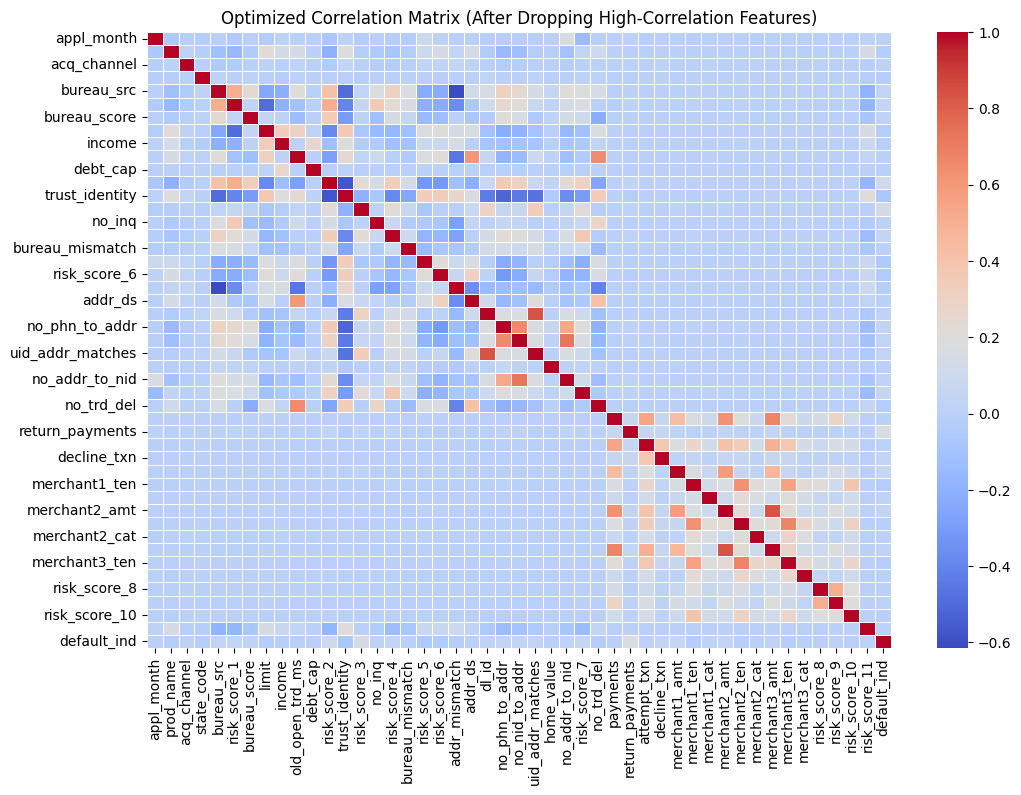

Remaining columns after removing highly correlated features: ['unique_identifier', 'appl_month', 'prod_name', 'acq_channel', 'state_code', 'bureau_src', 'risk_score_1', 'bureau_score', 'limit', 'income', 'old_open_trd_ms', 'debt_cap', 'risk_score_2', 'trust_identity', 'risk_score_3', 'no_inq', 'risk_score_4', 'bureau_mismatch', 'risk_score_5', 'risk_score_6', 'addr_mismatch', 'addr_ds', 'dl_id', 'no_phn_to_addr', 'no_nid_to_addr', 'uid_addr_matches', 'home_value', 'no_addr_to_nid', 'risk_score_7', 'no_trd_del', 'payments', 'return_payments', 'attempt_txn', 'decline_txn', 'merchant1_amt', 'merchant1_ten', 'merchant1_cat', 'merchant2_amt', 'merchant2_ten', 'merchant2_cat', 'merchant3_amt', 'merchant3_ten', 'merchant3_cat', 'risk_score_8', 'risk_score_9', 'risk_score_10', 'risk_score_11', 'default_ind']


In [ ]:
# This list includes redundant features to be dropped
high_corr_features_to_drop = [
    "basic_max_trd_tnr",       # correlated with old_open_trd_ms
    "basic_old_open_trd_ms",   # correlated with old_open_trd_ms
    "no_open_trd",             # correlated with no_trd
    "basic_no_trd",            # correlated with no_trd
    "no_trd",                  # correlated with no_trd_del
    "addr_changes",            # correlated with uid_addr_matches
    "uid_nid_matches",         # correlated with uid_addr_matches
    "no_uid_to_addr",          # correlated with no_nid_to_addr
    "income_incons",           # correlated with debt_cap
    "spend",                   # correlated with payments
    "merchant1",               # correlated with merchant1_ten
    "merchant2",               # correlated with merchant2_ten
    "merchant3"                # correlated with merchant3_ten
]

# Drop the redundant features
df_optimized = df.drop(columns=high_corr_features_to_drop)

# Select all columns except the first one
df_subset_optimized = df_optimized.iloc[:, 1:]
# Verify the new correlation matrix to confirm removal of redundant features
corr_matrix_optimized = df_subset_optimized.corr()

# Plot the optimized correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_optimized, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Optimized Correlation Matrix (After Dropping High-Correlation Features)")
plt.show()

# Display the final dataset columns
print("Remaining columns after removing highly correlated features:", df_optimized.columns.tolist())

In [ ]:
# Find and print all variable pairs with correlation greater than 0.85
high_corr_pairs = []

for i in range(corr_matrix_optimized.shape[0]):
    for j in range(i+1, corr_matrix_optimized.shape[1]):
        if abs(corr_matrix_optimized.iloc[i, j]) > 0.85:
            high_corr_pairs.append((corr_matrix_optimized.index[i], corr_matrix_optimized.columns[j], corr_matrix_optimized.iloc[i, j]))
n=0
# Display all variable pairs with correlation > 0.85
for pair in high_corr_pairs:
    n += 1
    print(f"Variables{n}: {pair[0]} and {pair[1]}, Correlation: {pair[2]:.2f}")
# Check if the list is empty and display a message if no pairs are found
if not high_corr_pairs:
    print("There is no pair of variables with correlation greater than 0.85")

There is no pair of variables with correlation greater than 0.85


In [ ]:
# Print the updated columns to confirm
print(df_subset_optimized['trust_identity'])
print(df_subset_optimized['addr_mismatch'])

0        2.0
1        1.0
2        0.0
3        2.0
4        1.0
        ... 
62479    2.0
62480    2.0
62481    2.0
62482    2.0
62483    2.0
Name: trust_identity, Length: 62484, dtype: float64
0        2.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
62479    0.0
62480    2.0
62481    0.0
62482    0.0
62483    0.0
Name: addr_mismatch, Length: 62484, dtype: float64


In [ ]:
!pip install joypy

In [ ]:
!pip install openpyxl

In [ ]:
from joypy import joyplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

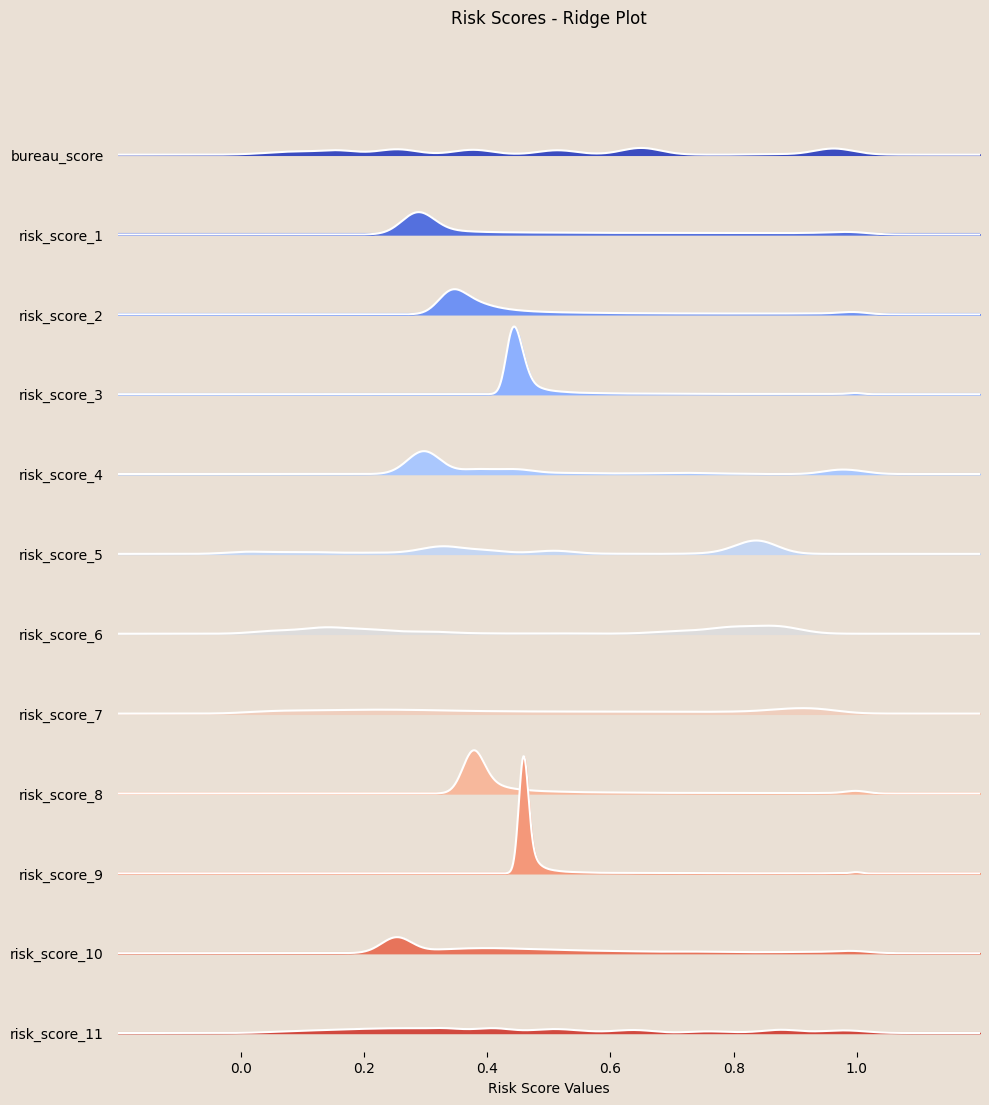

In [ ]:
# Select all necessary columns
StandardedDataColumn = [
    'bureau_score',
    'risk_score_1',
    'risk_score_2',
    'risk_score_3',
    'risk_score_4',
    'risk_score_5',
    'risk_score_6',
    'risk_score_7',
    'risk_score_8',
    'risk_score_9',
    'risk_score_10',
    'risk_score_11'
]

# Filter the data
df_filtered = df[StandardedDataColumn]

# 02. Plot the figure - using joyplot library
fig, ax = joyplot(df_filtered, by=None, column=StandardedDataColumn, figsize=(10, 12),
                  linecolor="white",  # Color of the ridge lines
                  colormap=sns.color_palette("coolwarm", as_cmap=True),
                  background='#eae0d5')  # Set background color

# Set the canvas background color
fig.set_facecolor('#eae0d5')

# Add title and labels
plt.xlabel('Risk Score Values')
plt.title("Risk Scores - Ridge Plot")

# Adjust layout to prevent overlapping
plt.subplots_adjust(top=0.95, bottom=0.1)

# Show the figure
plt.show()


In [ ]:
# Final Project
# Use data "df_optimized" which is deleted high corrlated variables.